In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

In [3]:
filepath = os.path.join("data", "processed", "buildings.gpkg")
gdf = gpd.read_file(filepath, driver="GPKG")
gdf.head(2)

ID_bat  ID_Concept EA_Heat  EA_HW  HeatPower      Need_Heat       Need_HW  \
0       8           0     gas    gas       84.0  120228.496894  40130.033035   
1      16           0   other  other       11.0   19659.863597    990.071041   

          SRE  TempLevel             Allocation        Epoch  SIA  GridArea  \
0  477.738489         70  indoor swimming pools            0   12         0   
1  141.580300         70         administration  .... - 1919    3         0   

   MaxSurf_PV_m2  CoolPower                                           geometry  
0            418        1.0  POLYGON ((333618.3162912441 5148286.238886707,...  
1             71        3.0  POLYGON ((333781.8668657038 5148335.068558921,...

In [4]:
horizon = "365D"
start = pd.to_datetime("2015-01-01 00:00:00")
end = start + pd.Timedelta(horizon)

folder = os.path.join("data", "processed", "needs")

In [5]:
keys = ["EL_kWh", "TH_kWh", "HW_kWh"]
for key in keys:
    gdf[key] = 0

print(datetime.datetime.now())
for idx, row in gdf.iterrows():
    print("--> {:>4}/{}".format(idx, len(gdf)), end="\r")
    filename = "{:04}.csv".format(idx)

    df = pd.read_csv(os.path.join(folder, filename), index_col=0, parse_dates=True)

    res = (df.sum()*0.25).to_dict()
    for key in keys:
        gdf.loc[idx, key] = res[key[:-1]]
del df
print("Loaded usefull energy profiles for {} buildings".format(len(gdf)))
print(datetime.datetime.now())

2019-08-16 15:20:19.996643
Loaded usefull energy profiles for 1369 buildings
2019-08-16 15:21:44.721321


<IPython.core.display.Javascript object>


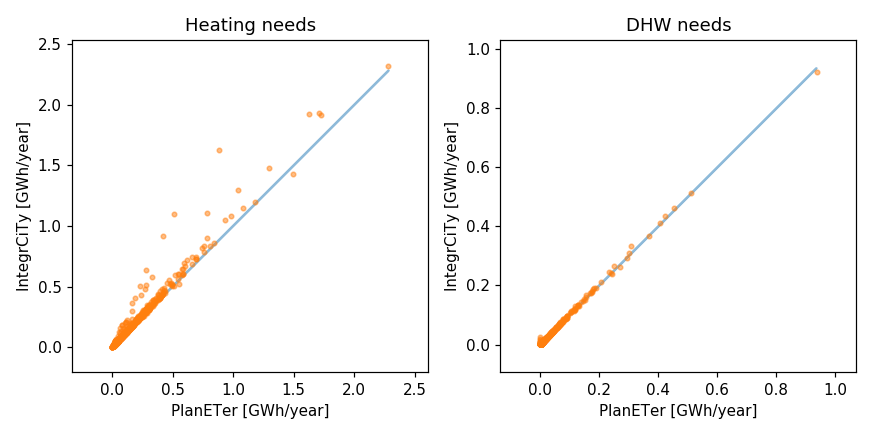

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# TH ++++++++++
ax[0].axis("equal")

ax[0].plot(gdf.Need_Heat*1e-6, gdf.Need_Heat*1e-6, "-", alpha=0.5)
ax[0].plot(gdf.Need_Heat*1e-6, gdf.TH_kWh*1e-6, ".", alpha=0.5)

ax[0].set_ylabel("IntegrCiTy [GWh/year]")
ax[0].set_xlabel("PlanETer [GWh/year]")
ax[0].set_title("Heating needs")

# HW ++++++++++
ax[1].axis("equal")

ax[1].plot(gdf.Need_HW*1e-6, gdf.Need_HW*1e-6, "-", alpha=0.5)
ax[1].plot(gdf.Need_HW*1e-6, gdf.HW_kWh*1e-6, ".", alpha=0.5)

ax[1].set_ylabel("IntegrCiTy [GWh/year]")
ax[1].set_xlabel("PlanETer [GWh/year]")
ax[1].set_title("DHW needs")

plt.tight_layout()
plt.savefig(os.path.join("images", "heat_demand_comparison.png"), dpi=150, bbox_inches="tight")

In [7]:
perf = pd.read_csv(os.path.join("data", "external", "perf_kbob.csv"), index_col=0)
n_gas = round(1 / perf.loc[1, "EF"], 1)
print("Estimated gas boiler efficiency: {:.2f}".format(n_gas))

Estimated gas boiler efficiency: 0.90


In [8]:
columns = ["Elec", "NGas"]
index = pd.date_range(start=start, end=end, freq="15min")
tot = pd.DataFrame(np.zeros(shape=(len(index), len(columns))), index=index, columns=columns)

print(datetime.datetime.now())
for idx, row in gdf.iterrows():
    print("--> {:>4}/{}".format(idx, len(gdf)), end="\r")
    filename = "{:04}.csv".format(idx)

    df = pd.read_csv(os.path.join(folder, filename), index_col=0, parse_dates=True)
    
    if row["GridArea"] == 1:
        tot.Elec += df.EL_kW
    
    if row["ID_Concept"] == 12:
        if row["EA_Heat"] == "gas":
            tot.NGas += df.TH_kW/n_gas
        
        if row["EA_HW"] == "gas":
            tot.NGas += df.HW_kW/n_gas
    
del df
print("Summed final energy profiles for {} buildings".format(len(gdf)))
print(datetime.datetime.now())

2019-08-16 15:21:45.381704
Summed final energy profiles for 1369 buildings
2019-08-16 15:23:09.929626


<IPython.core.display.Javascript object>


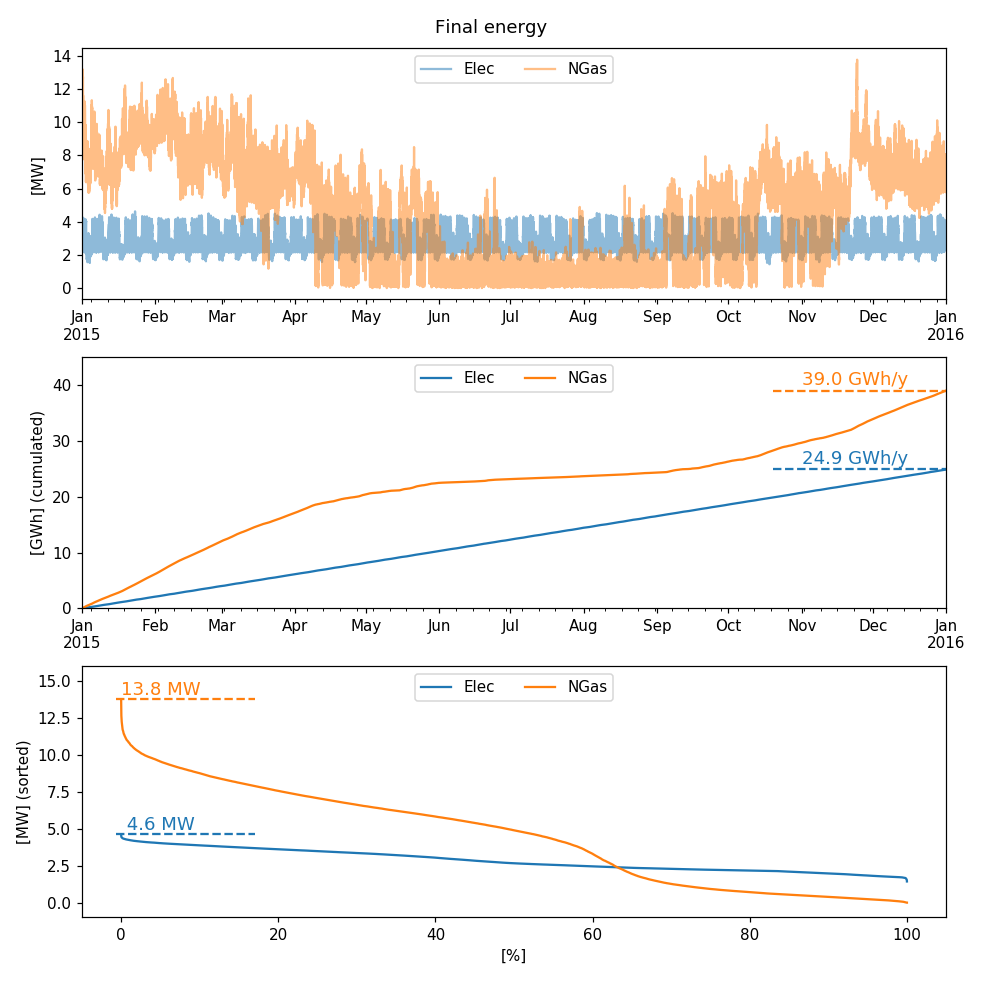

In [9]:
fig, ax = plt.subplots(3, figsize=(9, 9))

elec, ngas = tot.values.T*1e-3

elec.sort()
ngas.sort()

elec, ngas = elec[::-1], ngas[::-1]

(tot*1e-3).plot(ax=ax[0], alpha=0.5)
ax[0].set_ylabel("[MW]")
ax[0].legend(loc=9, ncol=2)

(0.25*tot.cumsum()*1e-6).plot(ax=ax[1])
ax[1].set_ylabel("[GWh] (cumulated)")
ax[1].legend(loc=9, ncol=2)

dd = (0.25 * tot.cumsum() * 1e-6).iloc[-1].round(1).to_dict()
for i, c in enumerate(tot.columns):
    ax[1].axhline(dd[c], xmin=0.8, linestyle="--", color="C{}".format(i))
    ax[1].annotate(
        "{:.1f} GWh/y".format(dd[c]),
        ("2015-11-01 00:00", dd[c] + 1),
        size="large",
        color="C{}".format(i),
    )

ax[1].set_ylim(0, 45)

ax[2].plot(np.linspace(0, 100, len(elec)), elec, label="Elec")
ax[2].plot(np.linspace(0, 100, len(ngas)), ngas, label="NGas")

for i, (c, pmax) in enumerate(zip(tot.columns, [elec[0], ngas[0]])):
    ax[2].axhline(pmax, xmin=0.04, xmax=0.2, linestyle="--", color="C{}".format(i))
    ax[2].annotate(
        "{:>4.1f} MW".format(pmax),
        (0, pmax + 0.3),
        size="large",
        color="C{}".format(i)
    )

ax[2].set_ylim(-1, 16)

ax[2].legend(loc=9, ncol=2)
ax[2].set_xlabel("[%]")
ax[2].set_ylabel("[MW] (sorted)")

fig.suptitle("Final energy")

fig.tight_layout()
fig.subplots_adjust(top=0.95)

plt.savefig(os.path.join("images", "networks_profiles.png"), dpi=150, bbox_inches="tight")

In [10]:
(tot*1e-3).describe().iloc[1:].T.round(2)

mean   std   min   25%   50%   75%    max
Elec  2.84  0.72  1.43  2.22  2.66  3.49   4.63
NGas  4.46  3.24  0.00  0.93  4.89  7.07  13.77